<a href="https://colab.research.google.com/github/Jmountford3/Portfolio-/blob/main/Alzheimer's_voice_sample_detection_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install visualkeras
!pip install tensorflow
!pip install noisereduce

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 10.6 MB/s eta 0:00:00


In [ ]:
import os
import warnings
import matplotlib.pyplot as plt #used for plotting mathematical graphs
import tensorflow as tf
import librosa # import audio processing library
import librosa.display # used for displaying the audio in graphs and charts
import noisereduce as nr
import numpy as np
import tqdm
import visualkeras
from scipy.io import wavfile
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, ConfusionMatrixDisplay # used to display metrics of the models performance
from sklearn.utils import class_weight
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LSTM, Bidirectional, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import Input
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from IPython.display import Image



In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Project/data')
warnings.filterwarnings('ignore')

Mounted at /content/drive


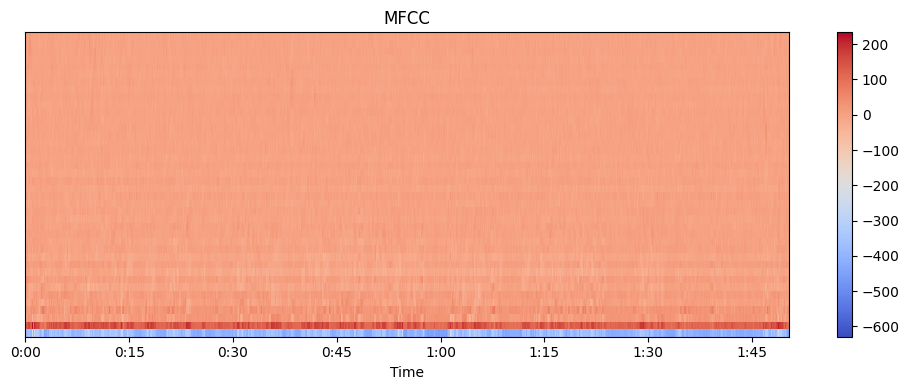

In [ ]:
audio_file = "mp3/Alzheimers/001-0.mp3"

y, sr = librosa.load(audio_file, sr=None)

mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40, dct_type =2, norm='ortho', lifter=0)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

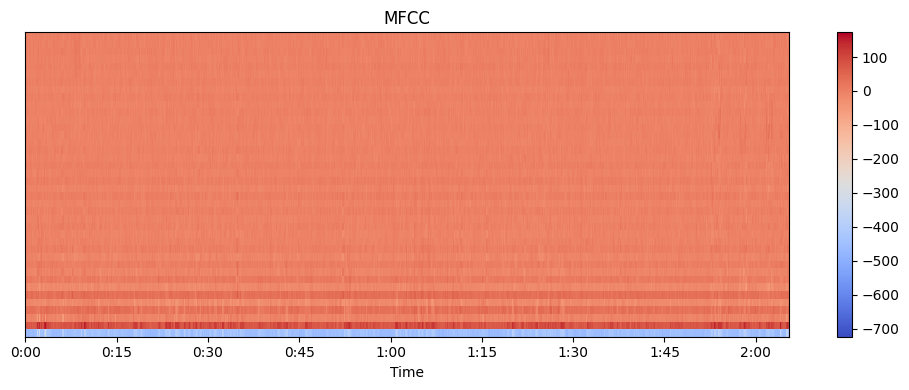

In [ ]:
audio_file = "mp3/Control/002-0.mp3"

y, sr = librosa.load(audio_file, sr=None)

mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40, dct_type =2, norm='ortho', lifter=0)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

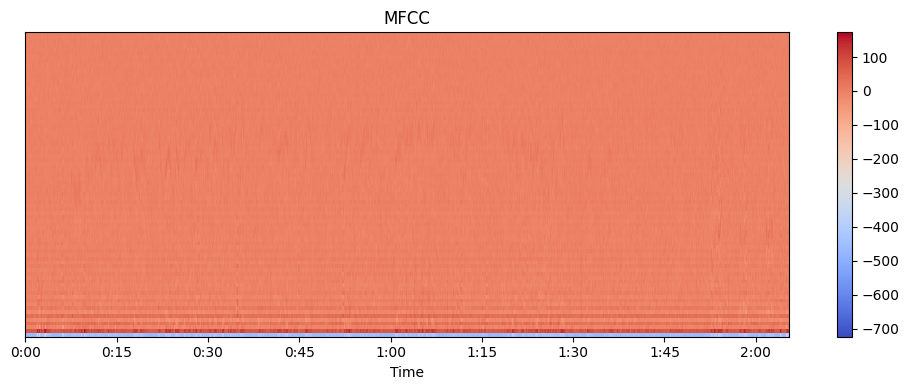

In [ ]:
audio_file = "mp3/Control/002-0.mp3"

y, sr = librosa.load(audio_file, sr=None)

mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=80, dct_type =2, norm='ortho', lifter=0)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

In [ ]:
sound_folder = 'mp3/Alzheimers'
mfcc_folder = 'mfcc/Alzheimers'

def extract_mfcc(sound_folder, mfcc_folder):
    y, sr = librosa.load(sound_folder, sr=None)

    if len(y) > sr:
      y = nr.reduce_noise(y=y, sr=sr, stationary=True, prop_decrease=0.8)

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40, dct_type =2, norm='ortho', lifter=0)
    np.save(mfcc_file_path, mfcc)


In [ ]:
for filename in tqdm.tqdm(os.listdir(sound_folder)):
  if filename.endswith('.mp3'):
    sound_file_path = os.path.join(sound_folder, filename)
    mfcc_file_path = os.path.join(mfcc_folder, filename.replace('.mp3', '.npy'))
    extract_mfcc(sound_file_path, mfcc_file_path)

100%|██████████| 334/334 [12:41<00:00,  2.28s/it]


In [ ]:
sound_folder = 'mp3/Control'
mfcc_folder = 'mfcc/Control'

# Create the output directory if it doesn't exist
os.makedirs(mfcc_folder, exist_ok=True)

for filename in tqdm.tqdm(os.listdir(sound_folder)):
  if filename.endswith('.mp3'):
    sound_file_path = os.path.join(sound_folder, filename)
    mfcc_file_path = os.path.join(mfcc_folder, filename.replace('.mp3', '.npy'))
    extract_mfcc(sound_file_path, mfcc_file_path)

100%|██████████| 269/269 [09:25<00:00,  2.10s/it]


In [ ]:
def load_mfcc(alz_folder = 'mfcc/Alzheimers', con_folder = 'mfcc/Control'):

  alz_files = [os.path.join(alz_folder, f) for f in os.listdir(alz_folder) if f.endswith('.npy')]
  con_files = [os.path.join(con_folder, f) for f in os.listdir(con_folder) if f.endswith('.npy')]

  alz_mfcc = [np.load(f) for f in alz_files]
  con_mfcc = [np.load(f) for f in con_files]

  # Find the minimum number of time frames across all MFCCs
  min_time_frames = min(mfcc.shape[1] for mfcc in alz_mfcc + con_mfcc)

  # pad MFCCs to have the same number of time frames
  alz_mfcc = [mfcc[:, :min_time_frames] for mfcc in alz_mfcc]
  con_mfcc = [mfcc[:, :min_time_frames] for mfcc in con_mfcc]

  mfccs = np.concatenate((alz_mfcc, con_mfcc))
  labels = np.concatenate(([1]*len(alz_mfcc), [0]*len(con_mfcc)))


  mfccs = np.array([x.T for x in mfccs])


  return mfccs, labels

In [ ]:
mfccs, labels = load_mfcc()

max_len = max([x.shape[1] for x in mfccs])
mfcc_pad = pad_sequences(mfccs, maxlen=max_len, padding='post', dtype='float32', truncating='post', value=0.0)


In [ ]:
mfcc = np.transpose(mfcc_pad, (0, 2, 1))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(mfcc_pad, y, test_size=0.2, random_state=42)

In [ ]:
class_weights = class_weight.compute_class_weight(
    'balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights)) #balance the class weights to account for class imbalance

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(482, 40, 40)
(482,)
(121, 40, 40)
(121,)


In [ ]:
num_samples = mfccs.shape[0] # The Number of samples within the set
num_timesteps = mfccs.shape[1]  # The Number of samples that the overall time series is split into
num_features = mfccs.shape[2] # The Number of features within each one of these segments
print (num_samples)
print (num_timesteps)
print (num_features)

603
673
40


In [ ]:
callback = EarlyStopping(monitor='accuracy', patience=10, verbose=0, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-10, verbose=0)

In [ ]:
epochs = 125
batch_size = 32
timesteps = mfcc_pad.shape[1]
dims = mfcc_pad.shape[2]

In [ ]:
input_layer = Input(shape=(timesteps, dims))

x1 = Bidirectional(LSTM(64, return_sequences=True))(input_layer)
x2 = Bidirectional(LSTM(128, return_sequences=True))(x1)
x3 = Bidirectional(LSTM(128, return_sequences=True))(x2)
x4 = Dropout(0.2)(x2)


x5 = GlobalAveragePooling1D()(x3)

x6 = Dense(64, activation='relu')(x4)
x7 = Dropout(0.3)(x5)
output_layer = Dense(1, activation='sigmoid')(x7)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer=AdamW(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_27 (InputLayer)     │ (None, 40, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_55                │ (None, 40, 128)        │        53,760 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_56                │ (None, 40, 256)        │       263,168 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_57                │ (None, 40, 256)        │       394,240 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_26     │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 711,425 (2.71 MB)

 Trainable params: 711,425 (2.71 MB)

 Non-trainable params: 0 (0.00 B)

None


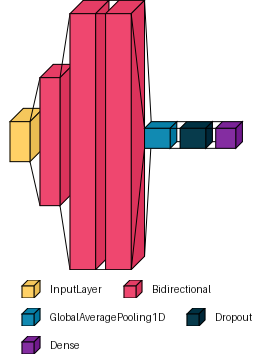

In [ ]:
visualkeras.layered_view(model, legend=True, scale_xy = 1) # displays a visualisation of the CNN model

In [ ]:
seed = 1234
np.random.seed(seed)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[callback, reduce_lr], class_weight=class_weights)

print(len(history.history['loss']))

Epoch 1/125
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 496ms/step - accuracy: 0.4265 - loss: 0.7919 - val_accuracy: 0.4380 - val_loss: 0.7165 - learning_rate: 0.0010
Epoch 2/125
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 307ms/step - accuracy: 0.5503 - loss: 0.6905 - val_accuracy: 0.4463 - val_loss: 0.7155 - learning_rate: 0.0010
Epoch 3/125
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 436ms/step - accuracy: 0.4849 - loss: 0.6990 - val_accuracy: 0.5620 - val_loss: 0.6869 - learning_rate: 0.0010
Epoch 4/125
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 323ms/step - accuracy: 0.5526 - loss: 0.7030 - val_accuracy: 0.4463 - val_loss: 0.7370 - learning_rate: 0.0010
Epoch 5/125
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 315ms/step - accuracy: 0.4907 - loss: 0.6952 - val_accuracy: 0.5124 - val_loss: 0.6949 - learning_rate: 0.0010
Epoch 6/125
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 390ms/step - accuracy: 0.5776 - loss: 0.6671 - val_accuracy: 0.4628 - val_loss: 0.7616 - learning_rate: 0.0010
Epoch 7/125
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - accuracy: 0.6128 - loss: 

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

NameError: name 'history' is not defined

In [ ]:
preds = model.predict(X_test)
preds = (preds > 0.5).astype(int)
y_true = y_test
directories = ['Alzheimers', 'Control']
print(classification_report(y_true, preds, target_names=directories))

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 409ms/step
              precision    recall  f1-score   support

  Alzheimers       0.52      0.61      0.56        54
     Control       0.63      0.55      0.59        66

    accuracy                           0.57       120
   macro avg       0.58      0.58      0.57       120
weighted avg       0.58      0.57      0.58       120



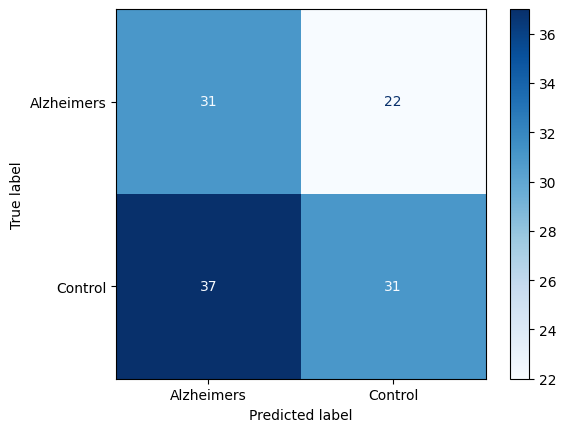

In [ ]:
cm = confusion_matrix(y_true, preds.flatten())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=directories)
disp.plot(cmap=plt.cm.Blues)
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


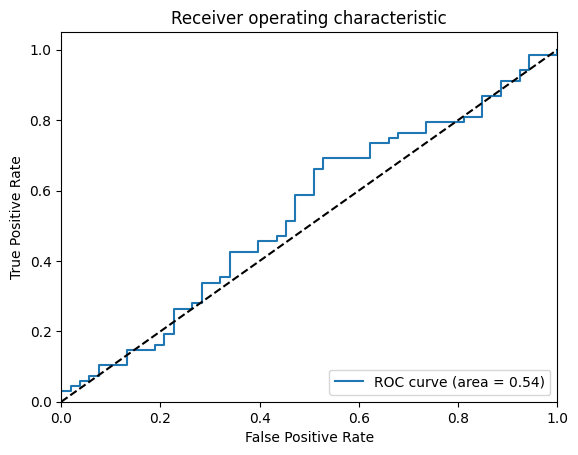

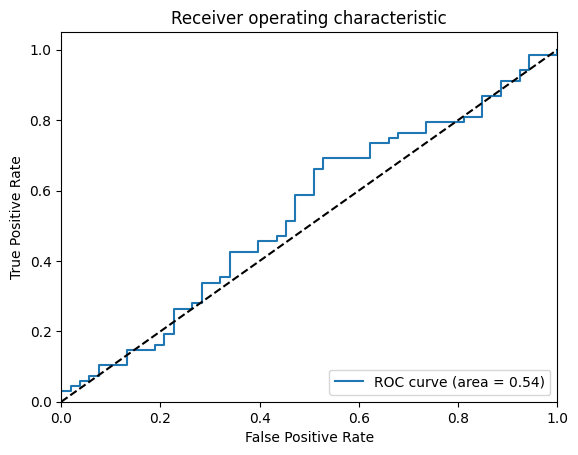

In [ ]:
y_score = model.predict(X_test) # get the prediction probabilities

num_classes = 2
# Compute ROC curve and ROC area for each class

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    # y_test is 1-dimensional, access it with a single index
    # y_score needs to be 1-dimensional as well for binary classification
    fpr[i], tpr[i], _ = roc_curve(y_test, y_score)
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot of a ROC curve for a specific class
for i in range(num_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

In [ ]:
accuracy_scores = []
loss_scores = []
precision_scores = []
recall_scores = []

for fold, (train_index, test_index) in enumerate(skf.split(mfcc_pad, labels)):
    print(f"Fold {fold+1}/{n_splits}")

    X_train, X_test = mfcc_pad[train_index], mfcc_pad[test_index]
    y_train, y_test = labels[train_index], labels[test_index]


    fold_class_weights = class_weight.compute_class_weight(
        'balanced', classes=np.unique(y_train), y=y_train)
    fold_class_weights = dict(enumerate(fold_class_weights))



    # Recreate the model to be iterated through each loop
    input_layer = Input(shape=(timesteps, dims))
    x1 = Bidirectional(LSTM(64, return_sequences=True))(input_layer)
    x2 = Bidirectional(LSTM(128, return_sequences=True))(x1)
    x3 = Bidirectional(LSTM(128, return_sequences=True))(x2)
    x4 = Dropout(0.2)(x3)
    x5 = GlobalAveragePooling1D()(x4)
    x6 = Dense(64, activation='relu')(x5)
    x7 = Dropout(0.3)(x6)
    output_layer = Dense(1, activation='sigmoid')(x7)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=AdamW(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

    history = model.fit(X_train, y_train,validation_data=(X_test, y_test),batch_size=batch_size,epochs=epochs,verbose=0, callbacks=[callback, reduce_lr],class_weight=fold_class_weights)


    loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
    loss_scores.append(loss)
    accuracy_scores.append(accuracy)
    precision_scores.append(precision) # Append precision score
    recall_scores.append(recall) # Append recall score


# Calculate and print the average scores outside the loop
print("\nAverage Metrics")
print(f"Average Loss: {np.mean(loss_scores):.4f}")
print(f"Average Accuracy: {np.mean(accuracy_scores):.4f}")
print(f"Average Precision: {np.mean(precision_scores):.4f}")
print(f"Average Recall: {np.mean(recall_scores):.4f}")

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5

Average Metrics
Average Loss: 0.7820
Average Accuracy: 0.5357
Average Precision: 0.6026
Average Recall: 0.4763
